In [1]:
# pip install lifelines
# !pip install nbimporter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_curve, auc

In [3]:
dataset_name = 'GSE63885'
data = pd.read_csv("../data/OV/"+dataset_name+"/"+dataset_name+"_data.csv")
data

,ID,PROM1,PROM2,OS(d),final_state,stage,grade,tumor_size
0,GSM1559299,7.032833,7.181727,104,1,3,4,2
1,GSM1559300,5.178788,11.197564,286,1,3,4,2
2,GSM1559301,9.785896,9.617907,357,1,4,3,1
3,GSM1559302,6.591305,10.134212,385,1,3,3,1
4,GSM1559303,7.842957,11.594253,414,1,3,2,1
...,...,...,...,...,...,...,...,...
70,GSM1559369,10.422614,8.560311,3750,1,3,3,0
71,GSM1559370,8.527269,10.506620,2797,1,3,3,2
72,GSM1559371,9.513137,10.414446,3145,0,2,3,0
73,GSM1559372,10.805115,9.475057,2801,0,3,3,2


In [4]:
# Univariate Cox-----------------------------------------------------
# X = data[['tumor_size']]
# y = data[['final_state','OS(d)']]

# Multivariate Cox-----------------------------------------------------
X = data[['PROM1','PROM2','stage','grade']]
y = data[['final_state','OS(d)']]

In [5]:
X

,PROM1,PROM2,stage,grade
0,7.032833,7.181727,3,4
1,5.178788,11.197564,3,4
2,9.785896,9.617907,4,3
3,6.591305,10.134212,3,3
4,7.842957,11.594253,3,2
...,...,...,...,...
70,10.422614,8.560311,3,3
71,8.527269,10.506620,3,3
72,9.513137,10.414446,2,3
73,10.805115,9.475057,3,3


In [6]:
df = pd.concat([X, y], axis=1)
cph = CoxPHFitter()
cph.fit(df, duration_col='OS(d)', event_col='final_state')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 75 total observations, 7 right-censored observations>
             duration col = 'OS(d)'
                event col = 'final_state'
      baseline estimation = breslow
   number of observations = 75
number of events observed = 68
   partial log-likelihood = -233.27
         time fit was run = 2025-04-11 08:25:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PROM1       0.01       1.01       0.06            -0.11             0.13                 0.90                 1.14
PROM2      -0.06       0.94       0.09            -0.24             0.12                 0.79                 1.12
stage       0.76       2.13       0.32             0.12             1.39                 1.13                 4.01
grade       0.53       1.70       0.21             0.11             0.95                 1.12                 2.58

            cmp to     z    p   -log2(p)
covariate                               
PROM1         0.00  0.19 0.85       0.23
PROM2         0.00 -0.68 0.49       1.02
stage         0.00  2.35 0.02       5.72
grade         0.00  2.49 0.01       6.30
---
Concordance = 0.61
Partial AIC = 474.54
log-likelihood ratio test = 13.05 on 4 df
-log2(p) of ll-ratio test = 6.50

In [7]:
# calculate the risk score
coefficients = cph.params_
df['risk_score'] = np.dot(df[['PROM1','PROM2', 'stage','grade']], coefficients[['PROM1','PROM2', 'stage','grade']])

In [8]:
c_index = concordance_index(df['OS(d)'], -df['risk_score'], df['final_state'])
print(f"C-index: {c_index}")

C-index: 0.6123282584478277


In [9]:
median_risk_score = df['risk_score'].median()
median_risk_score

3.344669341459432

In [10]:
from lifelines.statistics import logrank_test
cutoffs = np.linspace(df['risk_score'].min(), df['risk_score'].max()-0.1, 100)  # Range of potential cutoffs
logrank_pvals = []  # Store the p-values for each cutoff

# Calculate the log-rank test p-value for each cutoff
for cutoff in cutoffs:
    df['risk_group'] = np.where(df['risk_score'] <= cutoff, 'low_risk', 'high_risk')
    
    # Perform the log-rank test to compare survival between the two groups
    results = logrank_test(df['OS(d)'][df['risk_group'] == 'low_risk'],
                           df['OS(d)'][df['risk_group'] == 'high_risk'],
                           event_observed_A=df['final_state'][df['risk_group'] == 'low_risk'],
                           event_observed_B=df['final_state'][df['risk_group'] == 'high_risk'])
    logrank_pvals.append(results.p_value)

# Find the cutoff with the smallest p-value (best separation)
best_cutoff = cutoffs[np.argmin(logrank_pvals)]
best_cutoff

3.461098898033469

0.0006092864965722012


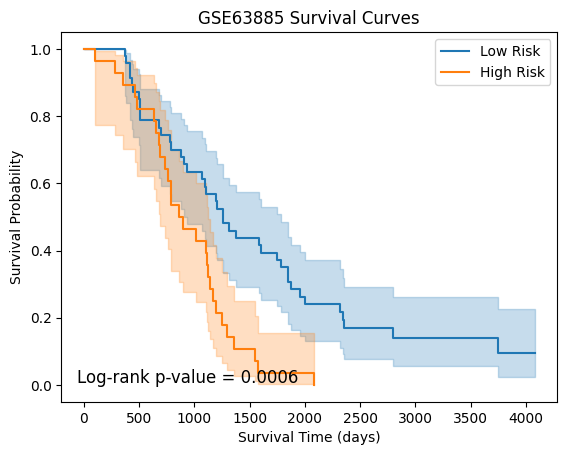

In [11]:
df['risk_group'] = np.where(df['risk_score'] <= best_cutoff, 'low_risk', 'high_risk')

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

# low-risk survival curve
low_risk = df[df['risk_group'] == 'low_risk']
kmf.fit(low_risk['OS(d)'], event_observed=low_risk['final_state'], label='Low Risk')
kmf.plot_survival_function()

# high-risk survival curve
high_risk = df[df['risk_group'] == 'high_risk']
kmf.fit(high_risk['OS(d)'], event_observed=high_risk['final_state'], label='High Risk')
kmf.plot_survival_function()

# log-rank test
results = logrank_test(low_risk['OS(d)'], high_risk['OS(d)'], event_observed_A=low_risk['final_state'], event_observed_B=high_risk['final_state'])

plt.title('{} Survival Curves'.format(dataset_name))
plt.xlabel('Survival Time (days)')
plt.ylabel('Survival Probability')
print(results.p_value)
if results.p_value>0.00002:
    plt.figtext(0.15, 0.15, f'Log-rank p-value = {results.p_value:.4f}', fontsize=12)
else:
    plt.figtext(0.15, 0.15, 'Log-rank p-value < 0.0001 ', fontsize=12)
plt.savefig('../pic/cox/{}-km.png'.format(dataset_name)) 
plt.legend()
plt.show()

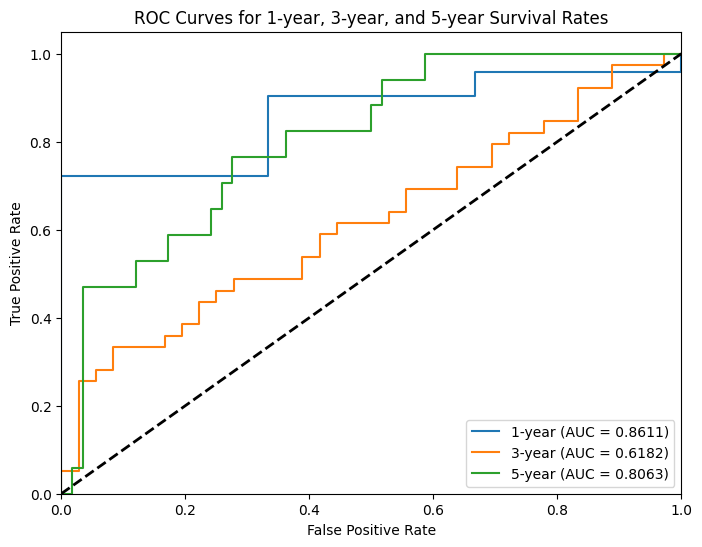

In [12]:
time_points = [365, 1095, 1825]
pred_survival = cph.predict_survival_function(df, times=time_points)

plt.figure(figsize=(8, 6))

for t in time_points:
    true_status = (df['OS(d)']> t).astype(int)  
    fpr, tpr, _ = roc_curve(true_status, pred_survival.loc[t])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{int(t/365)}-year (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for 1-year, 3-year, and 5-year Survival Rates')
plt.legend(loc='lower right')
plt.savefig('../pic/cox/{}-multi-year-ROC.png'.format(dataset_name)) 
plt.show()